# Playing with learning MMM
Based on https://github.com/zaai-ai/lab/blob/main/marketing/MMM/MMM.ipynb,

Medium post: https://towardsdatascience.com/mmm-bayesian-framework-for-marketing-mix-modeling-and-roas-ccade4005bd5

Using methods from https://github.com/mkelk/BookCode_Edition1_me

In [16]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats
from scipy.stats import entropy
from scipy.optimize import minimize
import pandas as pd
import datetime
import seaborn as sns

import utils
from utils import MyModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(521)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Load example data and do a bit of engineering
https://www.kaggle.com/datasets/yasserh/advertising-sales-dataset/code

In [18]:
df = pd.read_csv('data/Advertising Budget and Sales.csv')
df = df.rename(columns={'Unnamed: 0': 'id', 'TV Ad Budget ($)':'tv', 'Radio Ad Budget ($)': 'radio', 'Newspaper Ad Budget ($)': 'newspaper', 'Sales ($)': 'sales'})
df['ds'] = df['id'].apply(lambda x: pd.to_datetime("2024-02-26")-datetime.timedelta(weeks=len(df)-x))
df

id     tv  radio  newspaper  sales         ds
0      1  230.1   37.8       69.2   22.1 2020-05-04
1      2   44.5   39.3       45.1   10.4 2020-05-11
2      3   17.2   45.9       69.3    9.3 2020-05-18
3      4  151.5   41.3       58.5   18.5 2020-05-25
4      5  180.8   10.8       58.4   12.9 2020-06-01
..   ...    ...    ...        ...    ...        ...
195  196   38.2    3.7       13.8    7.6 2024-01-29
196  197   94.2    4.9        8.1    9.7 2024-02-05
197  198  177.0    9.3        6.4   12.8 2024-02-12
198  199  283.6   42.0       66.2   25.5 2024-02-19
199  200  232.1    8.6        8.7   13.4 2024-02-26

[200 rows x 6 columns]

# Initiate my MMM model

In [19]:
mymodel = MyModel(df, obsvar='sales', timevar="ds", features=['tv', 'radio', 'newspaper'])

# Exploratory analysis

### Sales over time

### Channel spend and sales from observed data

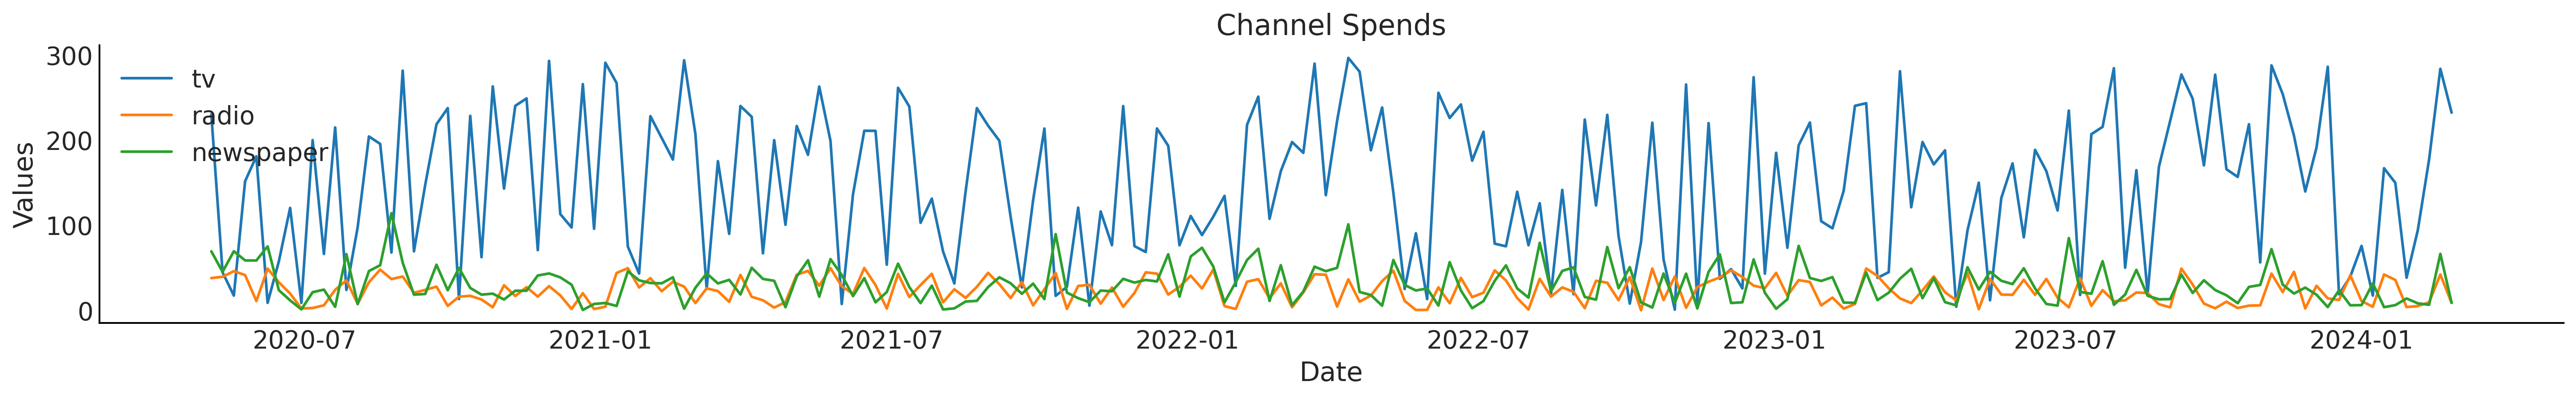

In [20]:
mymodel.plot_channel_spends()

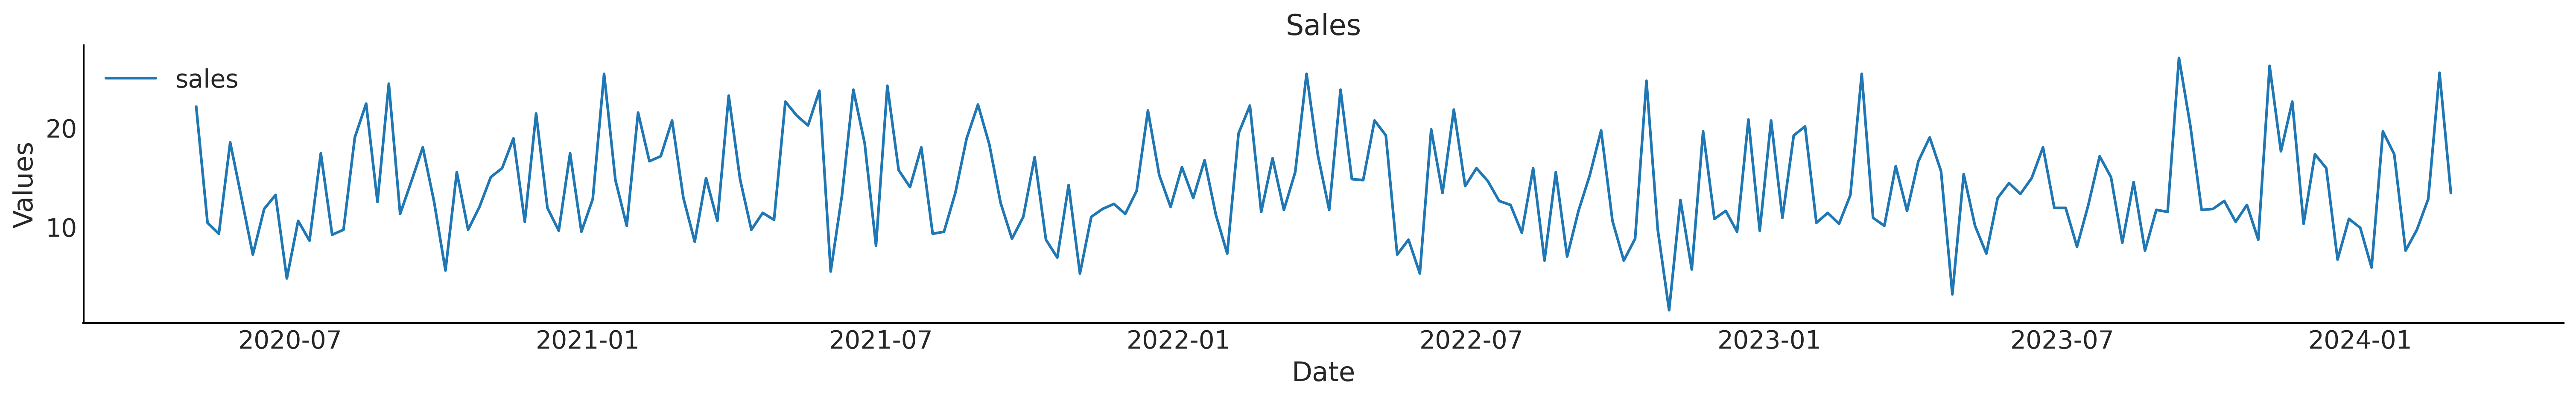

In [21]:
mymodel.plot_sales()

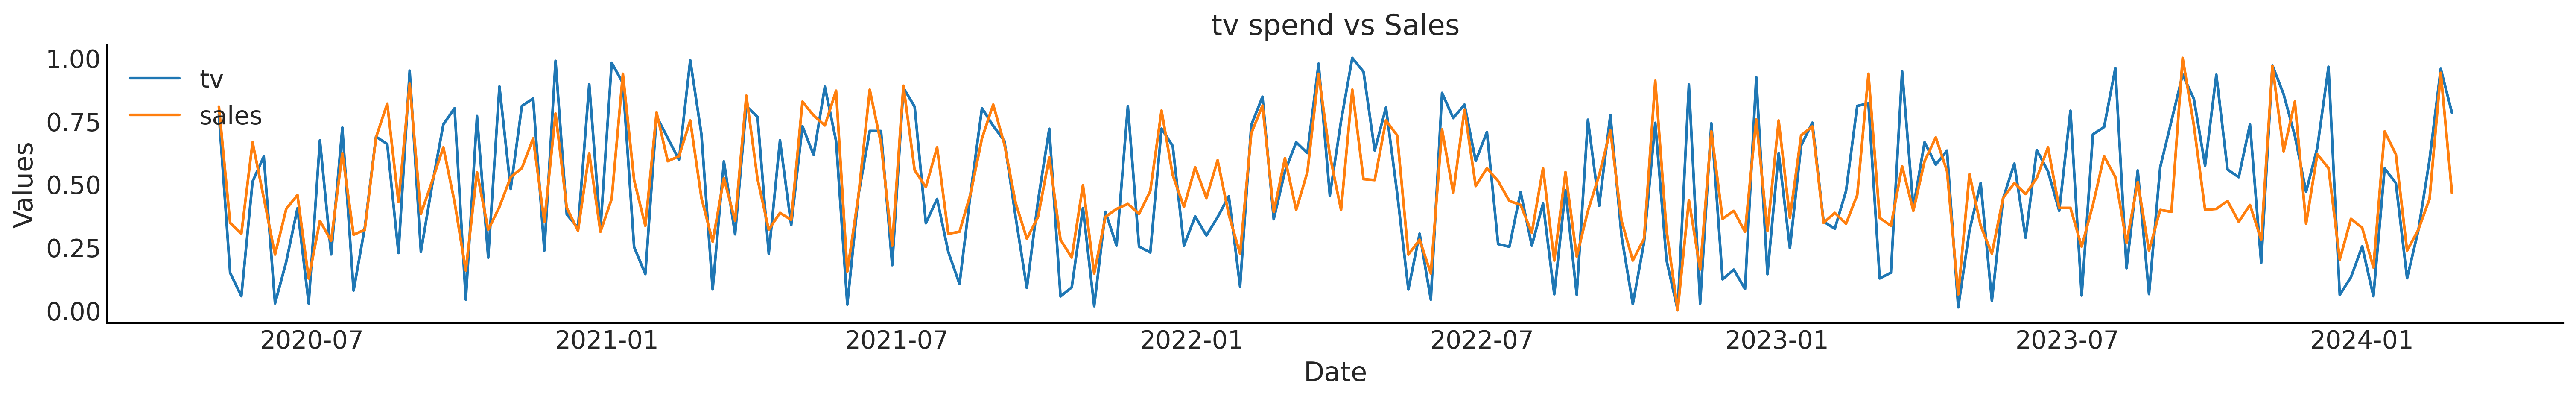

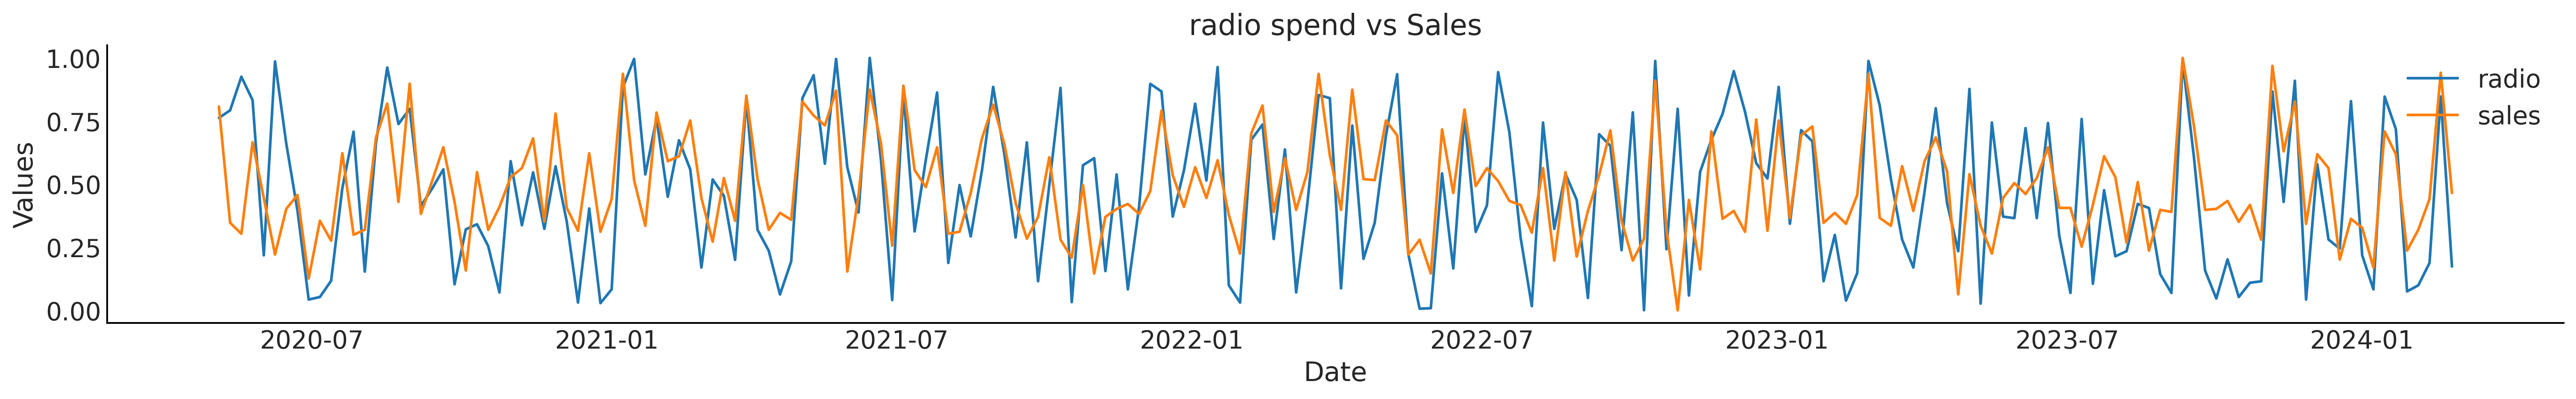

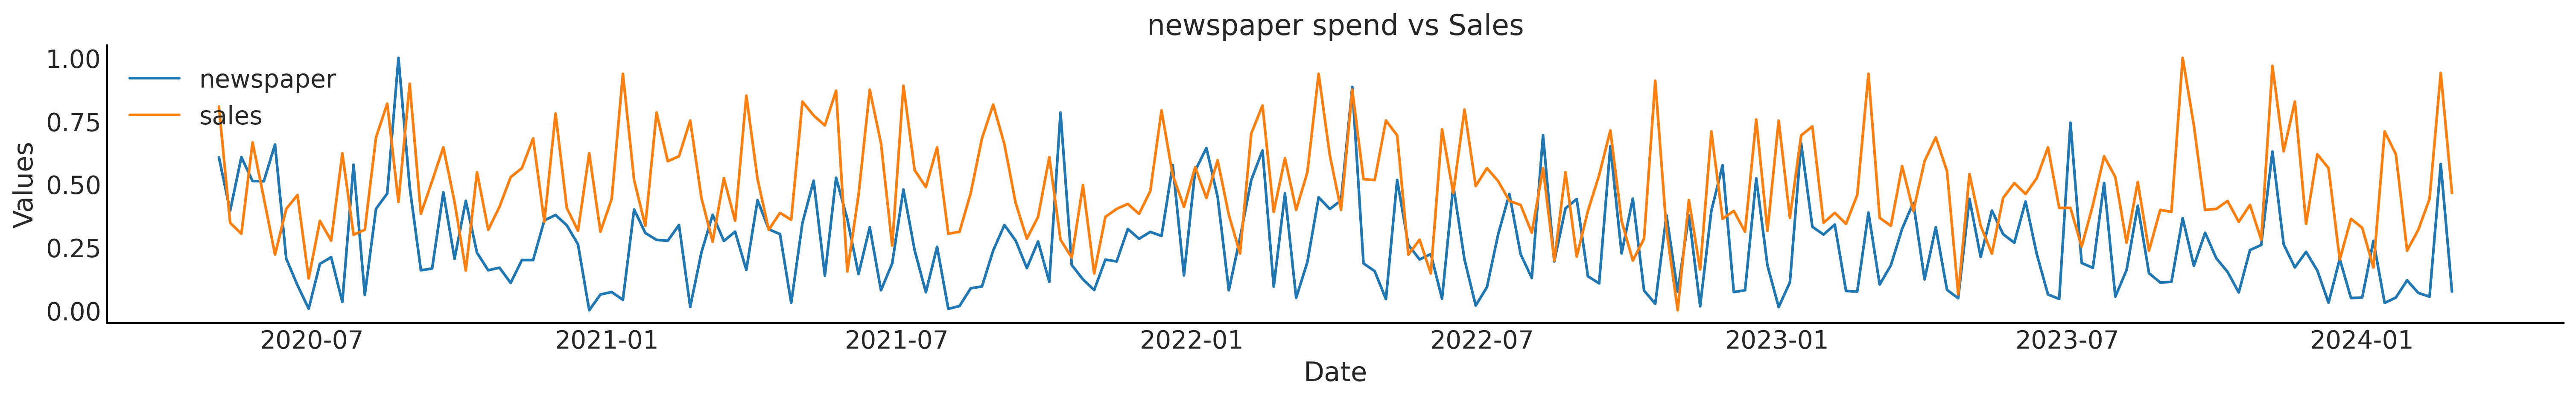

In [22]:
mymodel.plot_channel_spends_vs_sales()

### Correlation between variables

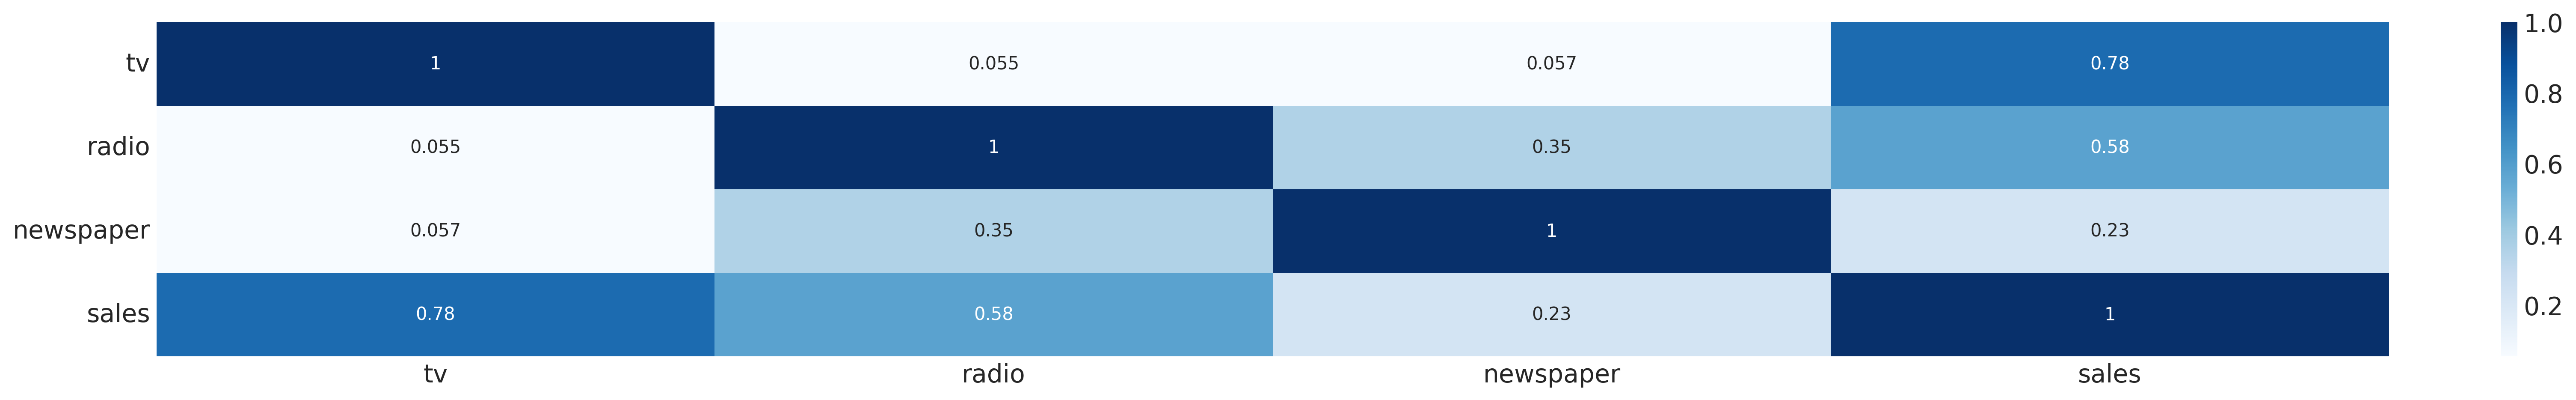

In [23]:
mymodel.plot_correlation_matrix()

# Simple example of modeling

### First some exploration

In [24]:
overall = mymodel.overall_numbers()
overall

{'Sales Overall Mean': 14.0225,
 'Sales Overall Variance': 27.22185301507538,
 'tv: Overall Mean Spend ': 147.0425,
 'tv: Overall total sales divided by total spend': 0.09536358535797473,
 'radio: Overall Mean Spend ': 23.264000000000006,
 'radio: Overall total sales divided by total spend': 0.6027553301237962,
 'newspaper: Overall Mean Spend ': 30.553999999999995,
 'newspaper: Overall total sales divided by total spend': 0.458941546115075}


### Declare a model in PyMC3

In [25]:
mymodel.fit()

Sampling: [beta_i, beta_tv, sigma, y_obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_i, beta_tv, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_obs]


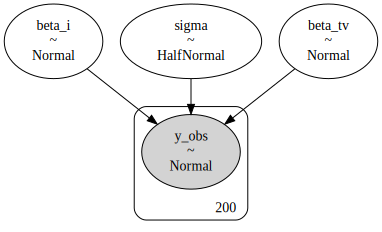

In [26]:
mymodel.show_model_graphviz()

### Chains and traces
Show distribution of the model parameters seen in the chains

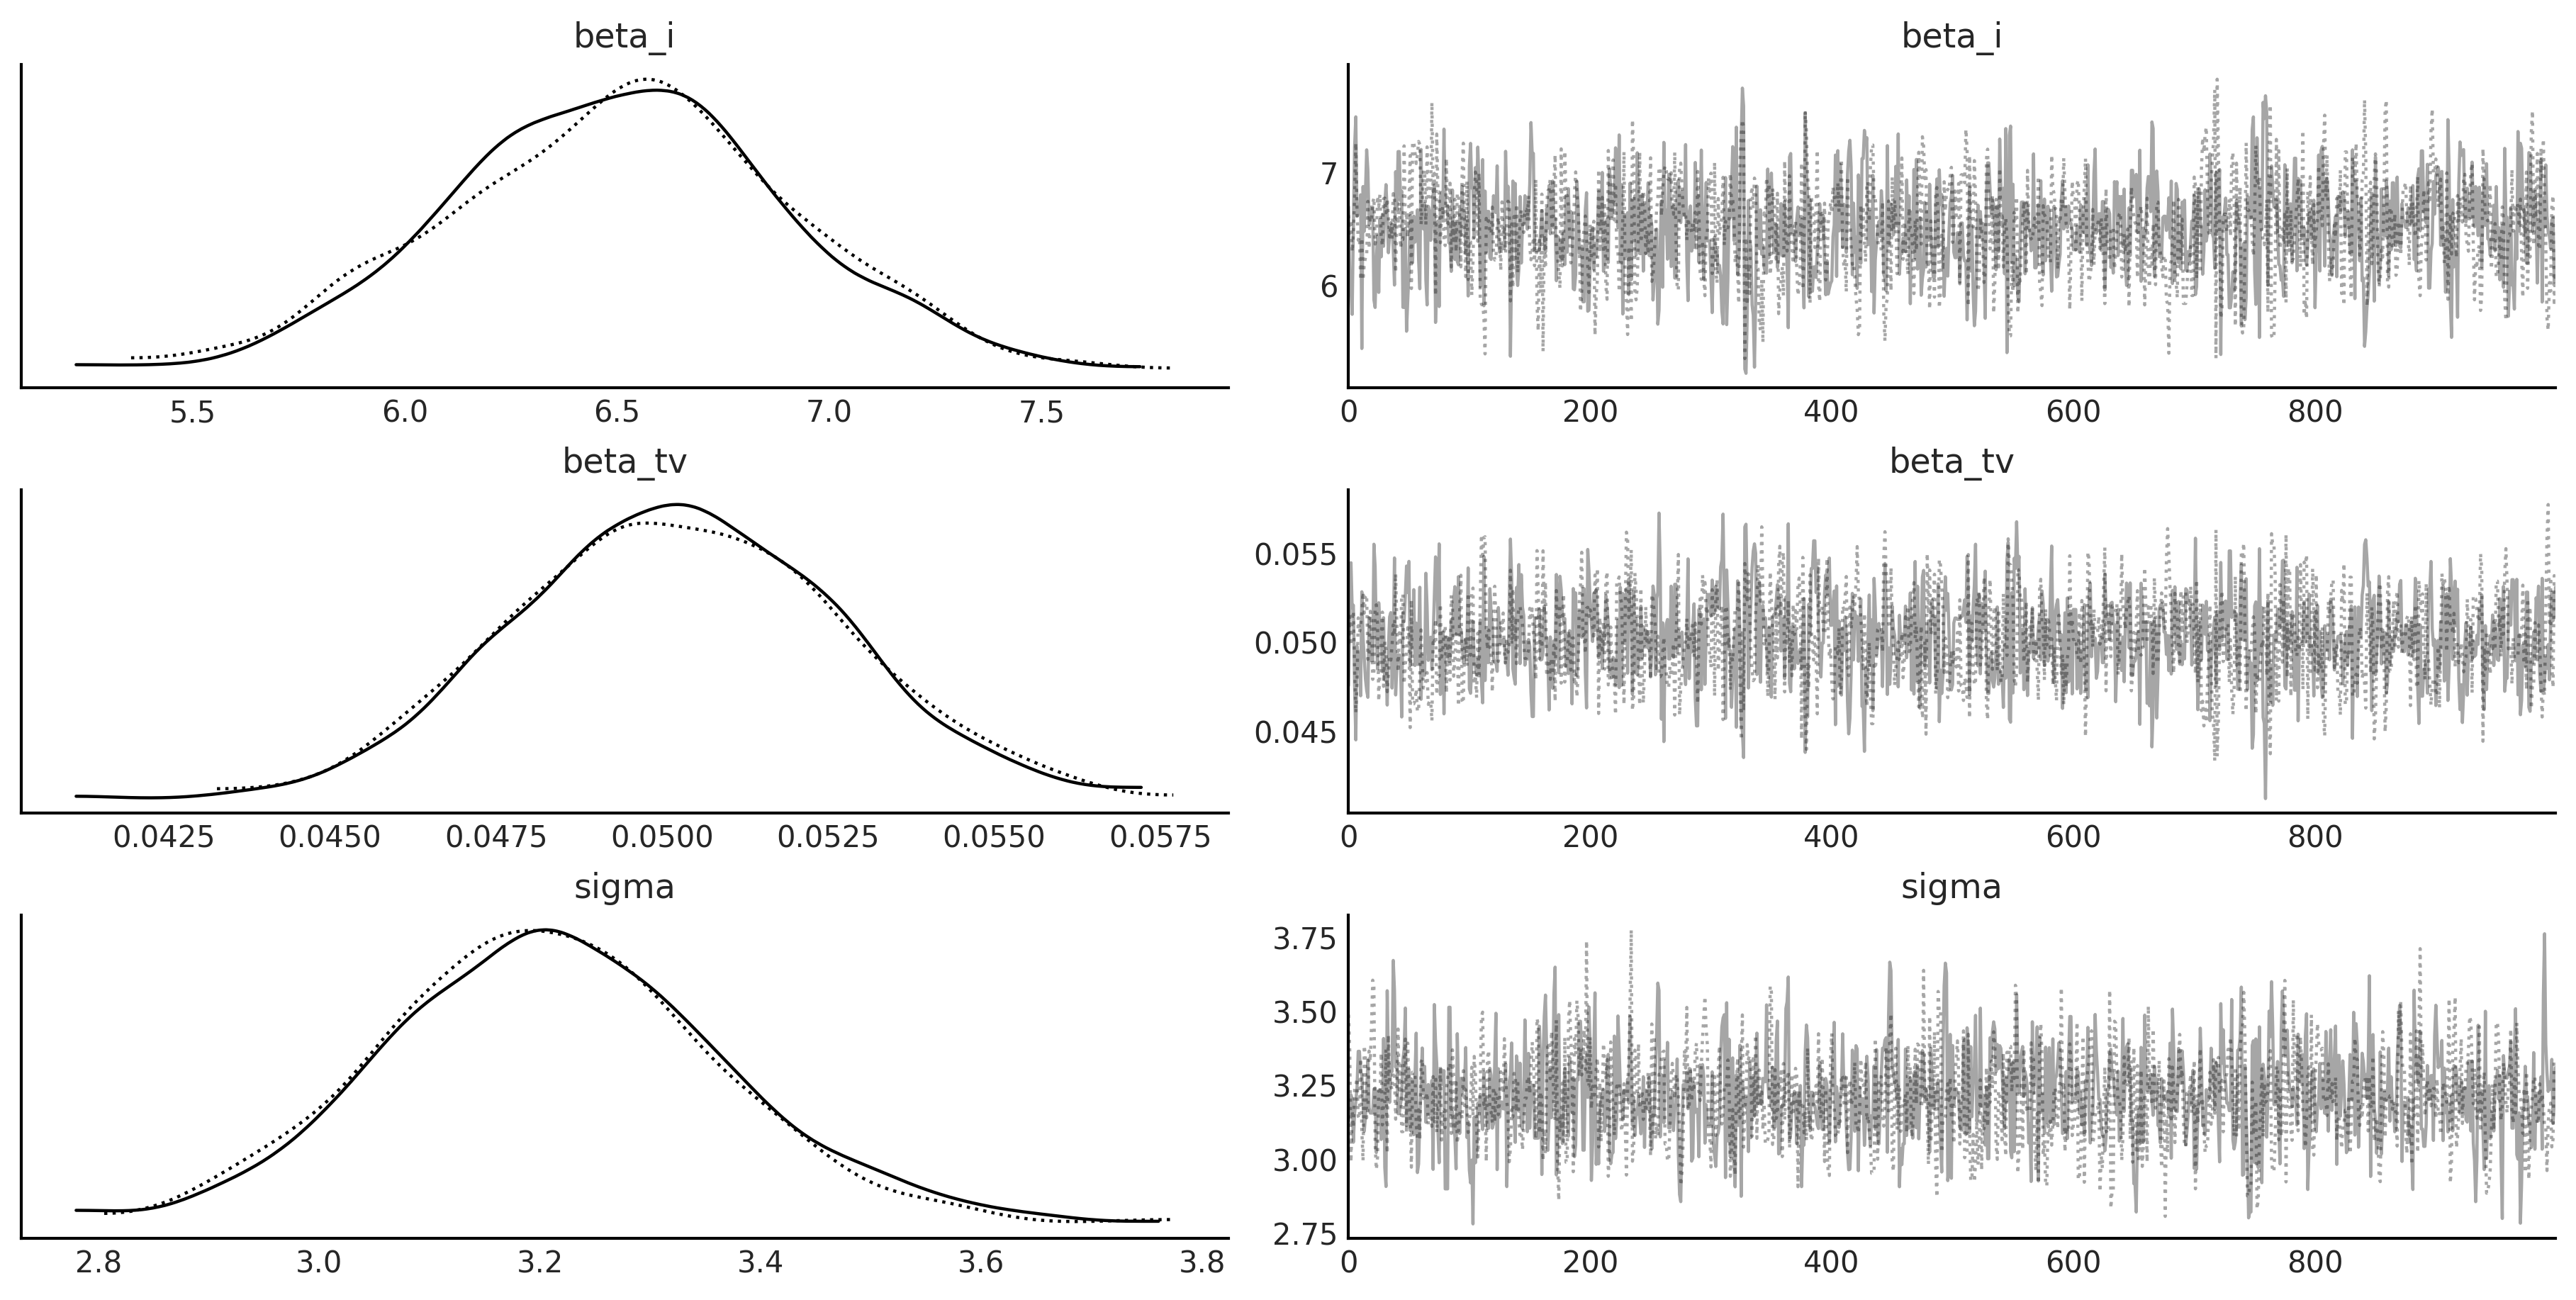

In [27]:
mymodel.show_chain_traces()

# Prior and posterior distributions

In [28]:
mymodel.show_prior_and_posterior_distribution()

# Understanding the quantities we can get from the modeling

Sampling: [beta_i, beta_tv, sigma, y_obs]


<Axes: >

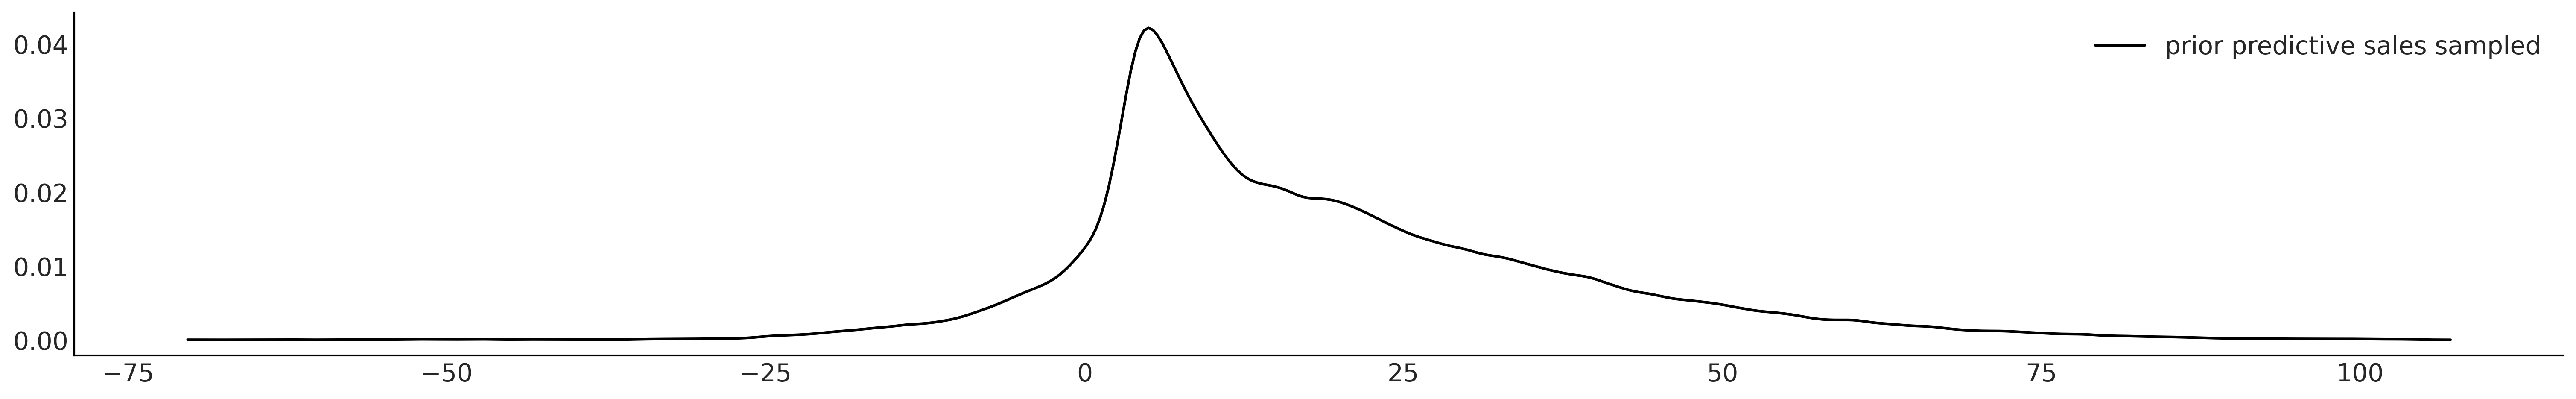

In [29]:
# 500 samples of y_obs generated from the prior predictive distribution
# Remember: 1 observation is 200 data-points, since there are 200 weeks in the dataset
prior_pred_y_obs = pm.sample_prior_predictive(500, mymodel.model).prior_predictive["y_obs"].values
az.plot_dist(prior_pred_y_obs.mean(axis=0), label="prior predictive sales sampled")


<Axes: >

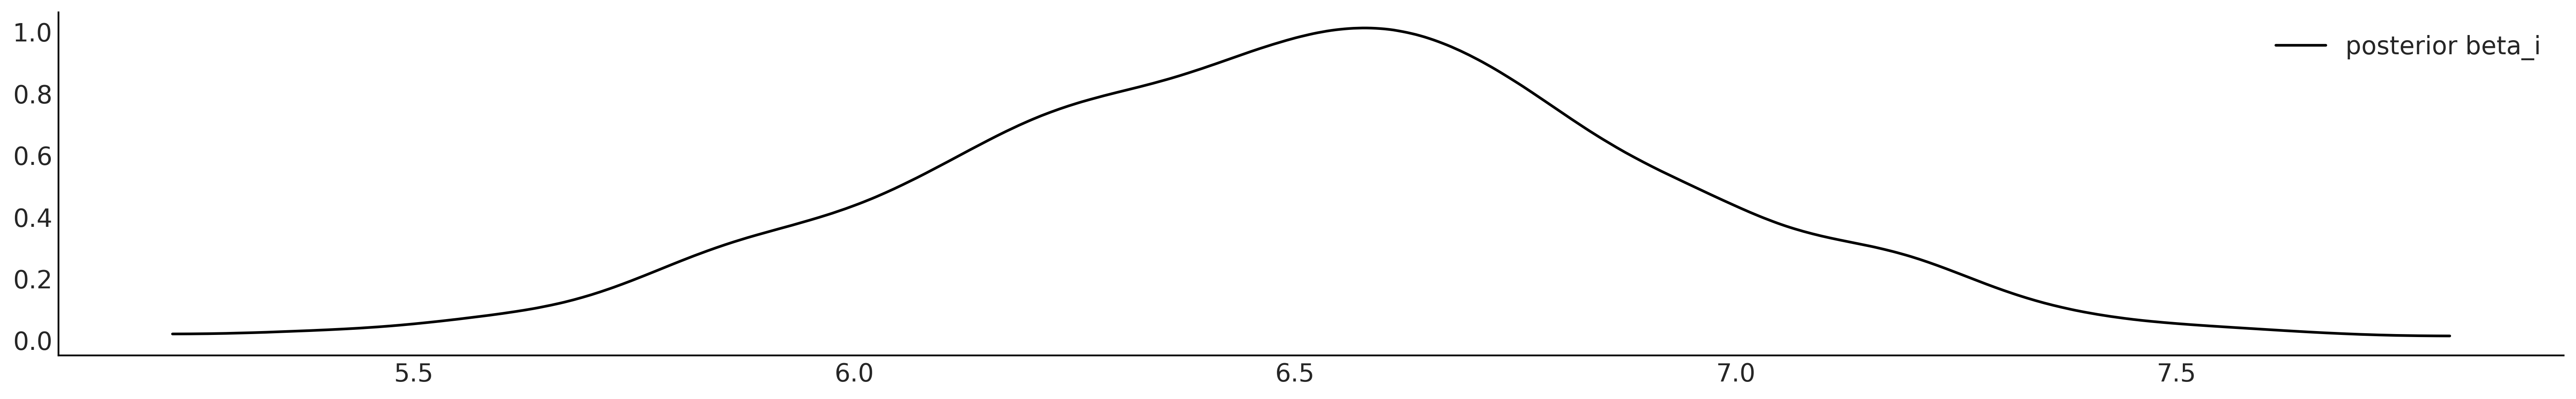

In [30]:
# plot the posterior predictive distribution of beta_tv
az.plot_dist(mymodel.idata_inf.posterior["beta_i"], label="posterior beta_i")

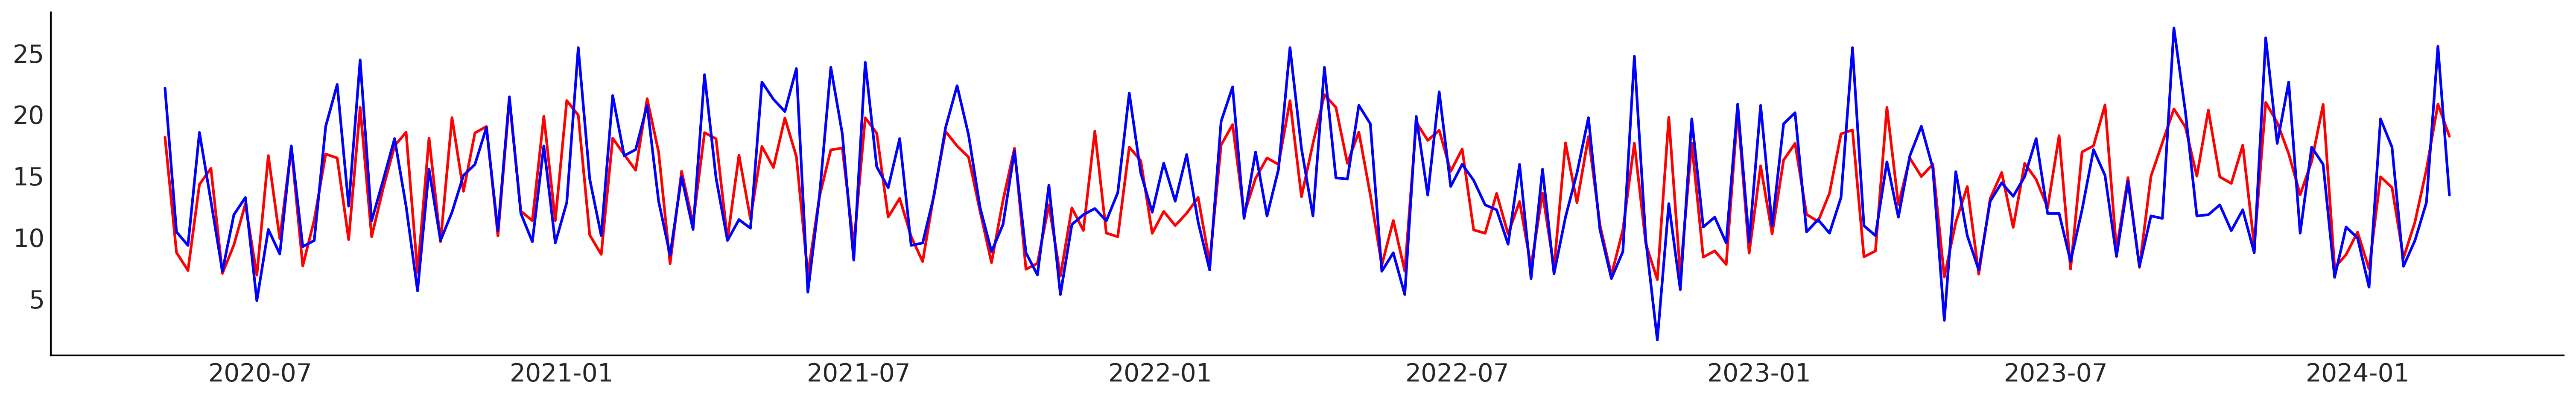

In [31]:
mymodel.plot_sales_vs_predicted()